# Deep Convolutional - Image Colorization
Image colorization of grayscale to rgb directly. This is order to see the limitation of using RGB as the output when computing the loss.

In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image

Note: you may need to restart the kernel to use updated packages.


## Import all Modules and Configure GPU

In [2]:
import os
import keras_tuner as kt
from numpy import asarray
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import PIL
import PIL.Image
import imageio.v2 as imageio
import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

## Configure GPU

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


2022-09-03 08:53:57.124931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 08:53:57.125239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 08:53:57.160297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 08:53:57.160513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 08:53:57.160666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [4]:
tf.__version__

'2.9.1'

In [5]:
root_dir = "result/anime_colorizing"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [6]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE):
        BUFFER_SIZE = 10000
        #ds = ds.cache(filename='/tmp/AnimeColorizing', name='AnimeColorizing')
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    #
    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='grayscale',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    #data_test_dir = pathlib.Path(data_dir.as_posix() + "/" + test_subdir)
    #image_count = len(list(data_test_dir.glob('**/*.??g')))
    #print("{0}: Found {1} files".format(data_test_dir, image_count))
#
    #test_ds = tf.keras.utils.image_dataset_from_directory(
    #    data_test_dir,
    #    interpolation='bilinear',
    #    color_mode='rgb',
    #    label_mode=None,
    #    follow_links=True,
    #    shuffle=False,
    #    image_size=image_size,
    #    batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    # Translate [0,255] -> [0, 1]
    normalized_train_ds = train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0)

    # Translate [0,255] -> [-1, 1]
    #normalized_test_ds = test_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0)

    return configure_for_performance(tf.data.Dataset.zip((normalized_train_ds, normalized_train_ds)), AUTOTUNE)


In [7]:
IMAGE_SIZE = (128, 128)

EPOCHS = 18

BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE)  # .batch(batch_size=BATCH_SIZE)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_images = train_images.with_options(options)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

data-colorize: Found 184327 files
Found 184327 files belonging to 1 classes.
Number of batches 2881 of 64 elements


## Augment Data

In [8]:

trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.10),
        width_factor=(-0.05, -0.10)),
    layers.RandomRotation(0.4)
])

def AgumentFunc(x, y):
    aX = trainAug(x)
    return (aX, aX)


trainAugmentedDS = (
    train_images
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#


ds_size = len(trainAugmentedDS)
train_size = int(0.8 * ds_size)
val_size = int(0.2 * ds_size)

train_ds = trainAugmentedDS.take(train_size)
val_ds = trainAugmentedDS.skip(train_size).take(val_size)

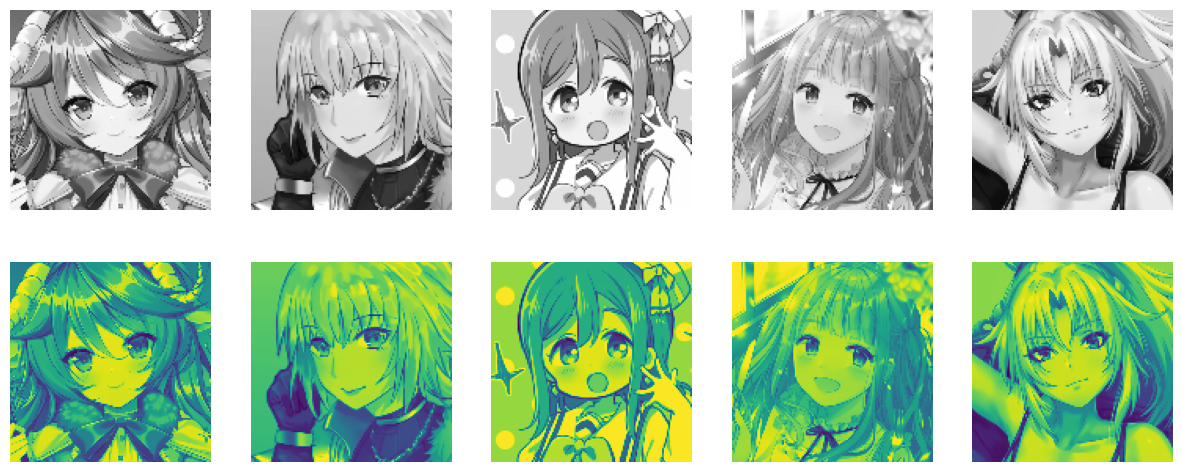

In [9]:

num_examples_to_generate = 5

plt.figure(figsize=(15, 6))
for images in train_images.take(1):
    for i in range(0, num_examples_to_generate):
        ax = plt.subplot(2, num_examples_to_generate, i + 1)
        trainImage, expectedImage = images
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow( (trainImage[i, :, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0,  cmap='gray' )
        plt.axis("off")
        ax = plt.subplot(2, num_examples_to_generate, num_examples_to_generate + 1 + i)
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow((expectedImage[i, :, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
        plt.axis("off")
plt.show()


## Creating The Model
The model is created, similar to a audo encoding. However, in this model, there is node latent space. Instead it uses more of pure convolution network.

In [16]:
def create_model(hp, input_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    num_layers = hp.Int('number_of_layers', min_value=2, max_value=4, step=1)

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2, kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        model.add(layers.UpSampling2D(size=(2, 2)))

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

    model.add(layers.Conv2D(3, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    def ssim_loss(y_true, y_pred):
        return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

    model.compile(optimizer=hp_optimizer,
                  loss=ssim_loss,
                  metrics=[ssim_loss,'accuracy'])

    return model


## Hyperparameter

In [17]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)


def model_builder(hp):
    with strategy.scope():
        model = create_model(hp, image_shape)
        return model

best_models = None
model = None

tuner = kt.Hyperband(model_builder,
                    objective='val_accuracy',
                    max_epochs=16,
                    factor=5,
                    directory='{0}/cache'.format(root_dir),
                    project_name=str.format('Colorizing - GrayScale Input - {0}', "Anime"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_ds.take(1000), epochs=EPOCHS, batch_size=BATCH_SIZE,
            callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN()], validation_data=val_ds.take(150), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


INFO:tensorflow:Reloading Oracle from existing project result/anime_colorizing/cache/Colorizing - GrayScale Input - Anime/oracle.json

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
uniform           |?                 |kernel_initializer
4                 |?                 |number_of_layers
7                 |?                 |kernel_filter_downscale
5                 |?                 |kernel_filter_upscale
rmsprop           |?                 |optimizer
4                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
1                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/4
INFO:tensorflow:Error reported to Coordinator: in user code:

    File "/tmp/ipykernel_6300/3299465399.py", line 44, in ssim_loss  *
        return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred[0,:,:,0], 1.0))

    ValueError: Shape (128, 128) must have rank at least 3
Traceback 

ValueError: in user code:

    File "/media/programming/projects/machineLearning/ML/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_6300/3299465399.py", line 44, in ssim_loss  *
        return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred[0,:,:,0], 1.0))

    ValueError: Shape (128, 128) must have rank at least 3


In [ ]:
def showResult(model, batchImage):
    maxNumImages = 5
    pred = (model.predict(batchImage) + 1.0) / 2.0
    nrElements = min(len(pred), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, maxNumImages))
    for image in batchImage:
        for i in range(nrElements):
            _, expectedImage = image

            ax = plt.subplot(2, maxNumImages, i + 1)
            # Transform pixel values from [-1,1] to [0,1]
            plt.imshow((expectedImage[i, :, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
            plt.axis("off")
            ax = plt.subplot(2, maxNumImages, maxNumImages + 1 + i)
            # Transform pixel values from [-1,1] to [0,1]
            plt.imshow(asarray(pred[i, :, :, :]).astype(dtype='float32'))
            plt.axis("off")
    plt.close()
    return fig

class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainData = trainData

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainData.take(1))
        fig.savefig("animeColor{0}.png".format(epoch))


In [ ]:


model_history = {}

checkpoint_path = "{0}/checkpoints/training_anime_coloring_grayscale/cp.ckpt".format(root_dir)
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)


model_history = model.fit(train_ds,
                          epochs=EPOCHS,
                          validation_data=val_ds,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])


model.save_weights(checkpoint_path)


Epoch 1/32


2022-08-15 09:53:38.347301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-08-15 09:53:39.158466: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


18444/18444 [==============================] - 355s 19ms/step - loss: 0.0103 - accuracy: 0.0043 - val_loss: 0.0013 - val_accuracy: 5.4053e-04
Epoch 2/32
 9117/18444 [=============>................] - ETA: 2:11 - loss: 0.0016 - accuracy: 0.0048

In [ ]:
model.save("{0}/dc-anime-colorization.h5".format(root_dir))


# Result

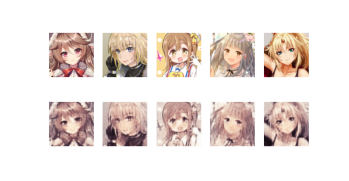

In [ ]:
plt.imshow(PIL.Image.open("animeColor{0}.png".format(EPOCHS - 1)))
plt.axis("off")
plt.show()

In [ ]:
anim_file = "{0}/anime-colorizing.gif".format(root_dir)

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{0}/animeColor*.png'.format(root_dir))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)

In [ ]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


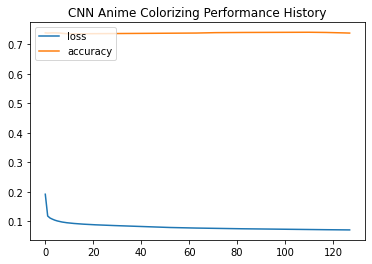

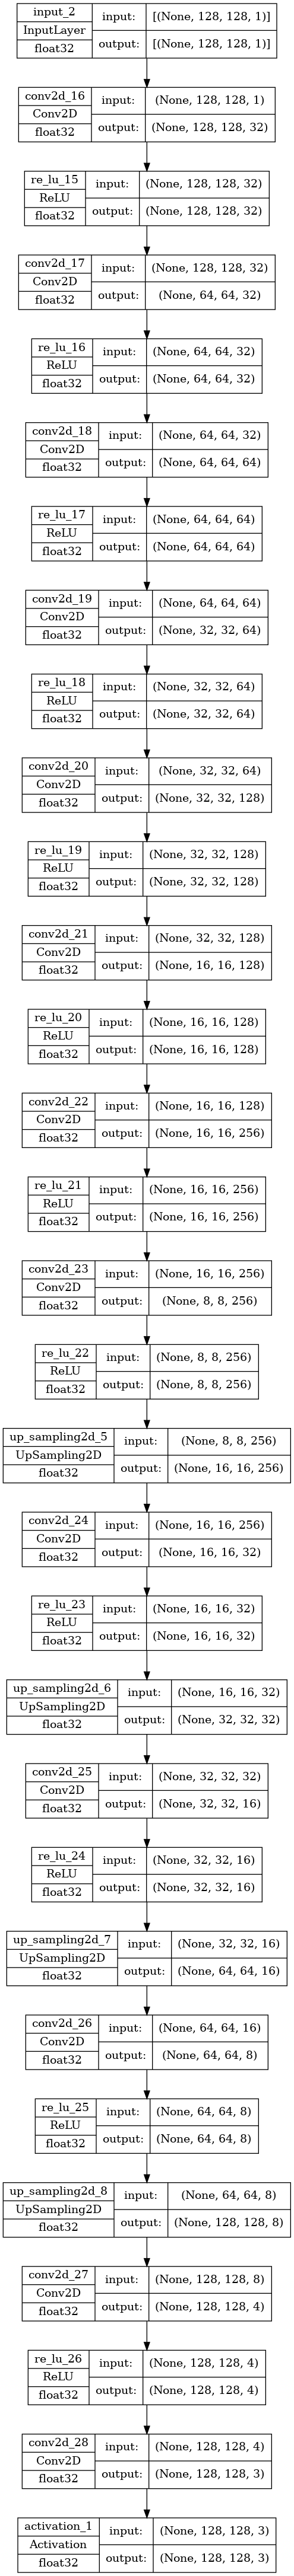

<Figure size 432x288 with 0 Axes>

In [ ]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Anime Colorizing"))

tf.keras.utils.plot_model(
    model, to_file=str.format('{0}/cnn_{1}_model.png', root_dir, "Anime Colorizing"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
